In [ ]:
import astropy.units as u
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

from tools_contsub_main import *
from tools_contsub_misc import *
from tools_contsub_units import *
from tools_contsub_plots import *
from tools_contsub_anchoring import * 
from tools_contsub_smoothregrid import * 

In [ ]:
galaxy = 'ngc1385'
galaxy_muse = galaxy
rootdir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/%s/' %galaxy
rootdir_bp = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/' 

narrowband_filter = 'f657n'
instrument_f555w  = 'uvis'
instrument_f65Xn = 'uvis'
instrument_f814w = 'uvis'

# Load files
hdu_muse_f555w  = get_hdu(rootdir, 'muse/%s*_%s_*F555W.fits' %(galaxy_muse.upper(), instrument_f555w.upper()))
hdu_muse_f65Xn  = get_hdu(rootdir, 'muse/%s*_%s_*%s.fits' %(galaxy_muse.upper(), instrument_f65Xn.upper(), narrowband_filter.upper()))
hdu_muse_f814w  = get_hdu(rootdir, 'muse/%s*_%s_*F814W.fits' %(galaxy_muse.upper(), instrument_f814w.upper()))
hdu_muse_stars  = get_hdu(rootdir, 'muse/%s_starmask.fits' %galaxy_muse.upper())
hdu_muse_neb    = get_hdu(rootdir, 'muse/%s_nebmask.fits' %galaxy_muse.upper())
hdu_muse        = get_hdu(rootdir, 'muse/%s*_MAPS.fits' %galaxy_muse.upper(), 'all')

hdu_hst_f555w   = get_hdu(rootdir, 'hst/%s*_%s_*f555w*.fits' %(galaxy, instrument_f555w))
hdu_hst_f65Xn   = get_hdu(rootdir, 'hst/%s*_%s_*%s*.fits' %(galaxy, instrument_f65Xn, narrowband_filter))
hdu_hst_f814w   = get_hdu(rootdir, 'hst/%s*_%s_*f814w*.fits' %(galaxy, instrument_f814w))

# Get resolution 
hst_res  = 0.07 * u.arcsec
_, file_muse_f65Xn = get_hdu(rootdir, 'muse/%s*_%s_*%s.fits' %(galaxy_muse.upper(), instrument_f65Xn.upper(), narrowband_filter.upper()), return_filename=True)
muse_res = np.float32(file_muse_f65Xn.split('asec')[0].split('-')[-1]) * u.arcsec

# Get filter curve info
bp = get_bandpassinfo(rootdir_bp)

In [3]:
# Make paths
make_paths(rootdir)
remove_paths(rootdir)

# Convert units 
hdu_hst_f555w = get_nanzeros(hdu_hst_f555w)
hdu_hst_f65Xn = get_nanzeros(hdu_hst_f65Xn)
hdu_hst_f814w = get_nanzeros(hdu_hst_f814w)

hdu_hst_f555w = get_electrons_2_ergcm2sA(hdu_hst_f555w)
hdu_hst_f65Xn = get_electrons_2_ergcm2sA(hdu_hst_f65Xn)
hdu_hst_f814w = get_electrons_2_ergcm2sA(hdu_hst_f814w)

# hdu_hst_f555w = get_electrons_2_ergcm2sA(hdu_hst_f555w, bp['%s_%s' %(instrument_f555w.upper(), 'F555W')]['unit_response'])
# hdu_hst_f65Xn = get_electrons_2_ergcm2sA(hdu_hst_f65Xn, bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['unit_response'])
# hdu_hst_f814w = get_electrons_2_ergcm2sA(hdu_hst_f814w, bp['%s_%s' %(instrument_f814w.upper(), 'F814W')]['unit_response'])

hdu_muse_f555w = get_Jy_2_ergcm2sA(hdu_muse_f555w, bp['%s_%s' %(instrument_f555w.upper(), 'F555W')]['pivot'])
hdu_muse_f65Xn = get_Jy_2_ergcm2sA(hdu_muse_f65Xn, bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['pivot'])
hdu_muse_f814w = get_Jy_2_ergcm2sA(hdu_muse_f814w, bp['%s_%s' %(instrument_f814w.upper(), 'F814W')]['pivot'])

# Smooth and regrid to MUSE
hdu_hst_f555w_sm = get_smooth(hdu_hst_f555w, hst_res, muse_res)
hdu_hst_f65Xn_sm = get_smooth(hdu_hst_f65Xn, hst_res, muse_res)
hdu_hst_f814w_sm = get_smooth(hdu_hst_f814w, hst_res, muse_res)

hdu_hst_f555w_smre = get_regrid(hdu_hst_f555w_sm, hdu_muse_f555w)
hdu_hst_f65Xn_smre = get_regrid(hdu_hst_f65Xn_sm, hdu_muse_f65Xn)
hdu_hst_f814w_smre = get_regrid(hdu_hst_f814w_sm, hdu_muse_f814w)

# Anchor filter flux density to MUSE
hdu_hst_f555w_an, hdu_hst_f555w_smrean, fit_f555w = get_anchoring_offset(hdu_muse_f555w, hdu_hst_f555w_smre, hdu_hst_f555w, hdu_muse_stars, 'f555w', rootdir)
hdu_hst_f65Xn_an, hdu_hst_f65Xn_smrean, fit_f65Xn = get_anchoring_offset(hdu_muse_f65Xn, hdu_hst_f65Xn_smre, hdu_hst_f65Xn, hdu_muse_stars, narrowband_filter, rootdir)
hdu_hst_f814w_an, hdu_hst_f814w_smrean, fit_f814w = get_anchoring_offset(hdu_muse_f814w, hdu_hst_f814w_smre, hdu_hst_f814w, hdu_muse_stars, 'f814w', rootdir)

# Make check plots
make_plots_diff(hdu_hst_f555w_smrean, hdu_muse_f555w, hdu_muse_stars, 'f555w', rootdir)
make_plots_diff(hdu_hst_f65Xn_smrean, hdu_muse_f65Xn, hdu_muse_stars, narrowband_filter, rootdir)
make_plots_diff(hdu_hst_f814w_smrean, hdu_muse_f814w, hdu_muse_stars, 'f814w', rootdir)

# Continuum subtract 
hdu_muse_halpha, hdu_muse_cont = get_contsub(hdu_muse_f65Xn.copy(), 
                                hdu_muse_f555w.copy(), 
                                hdu_muse_f814w.copy(), 
                                bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['pivot'], 
                                bp['%s_%s' %(instrument_f555w.upper(), 'F555W')]['pivot'], 
                                bp['%s_%s' %(instrument_f814w.upper(), 'F814W')]['pivot'])  

hdu_hst_an_halpha, hdu_hst_an_cont = get_contsub(hdu_hst_f65Xn_an.copy(), 
                                hdu_hst_f555w_an.copy(), 
                                hdu_hst_f814w_an.copy(), 
                                bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['pivot'], 
                                bp['%s_%s' %(instrument_f555w.upper(), 'F555W')]['pivot'], 
                                bp['%s_%s' %(instrument_f814w.upper(), 'F814W')]['pivot'])       

hdu_hst_halpha, hdu_hst_cont = get_contsub(hdu_hst_f65Xn.copy(), 
                                hdu_hst_f555w.copy(), 
                                hdu_hst_f814w.copy(), 
                                bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['pivot'], 
                                bp['%s_%s' %(instrument_f555w.upper(), 'F555W')]['pivot'], 
                                bp['%s_%s' %(instrument_f814w.upper(), 'F814W')]['pivot'])

# Convert units
photbw = bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['rectwidth']
hdu_hst_f65Xn_anf =  get_ergcm2sA_2_ergcm2s(hdu_hst_f65Xn_an, photbw)
hdu_muse_halpha = get_ergcm2sA_2_ergcm2s(hdu_muse_halpha, photbw)
hdu_hst_an_halpha = get_ergcm2sA_2_ergcm2s(hdu_hst_an_halpha, photbw)
hdu_hst_halpha = get_ergcm2sA_2_ergcm2s(hdu_hst_halpha, photbw)
hdu_muse_cont = get_ergcm2sA_2_ergcm2s(hdu_muse_cont, photbw)
hdu_hst_an_cont = get_ergcm2sA_2_ergcm2s(hdu_hst_an_cont, photbw)
hdu_hst_cont = get_ergcm2sA_2_ergcm2s(hdu_hst_cont, photbw)

# Convert units
make_plots_muse_comp(hdu_muse_halpha, hdu_muse['HA6562_FLUX'], True, rootdir)
make_plots_muse_comp(hdu_muse_halpha, hdu_muse['HA6562_FLUX'], False, rootdir)
make_plots_hst_comp(hdu_hst_an_halpha, hdu_hst_halpha, True, rootdir)
make_plots_hst_comp(hdu_hst_an_halpha, hdu_hst_halpha, False, rootdir)

[INFO] Image convolution complete.
[INFO] Smoothing process completed.
[INFO] Reprojecting the input image to match the template WCS...
[INFO] Performing image reprojection...
[INFO] Image reprojection complete.
[INFO] Scaling the output data to conserve flux with factor 25.48
[INFO] Flux scaling complete.
[INFO] Reprojection process completed.
[INFO] Reprojecting the input image to match the template WCS...
[INFO] Performing image reprojection...
[INFO] Image reprojection complete.
[INFO] Scaling the output data to conserve flux with factor 25.48
[INFO] Flux scaling complete.
[INFO] Reprojection process completed.
[INFO] Reprojecting the input image to match the template WCS...
[INFO] Performing image reprojection...
[INFO] Image reprojection complete.
[INFO] Scaling the output data to conserve flux with factor 25.48
[INFO] Flux scaling complete.
[INFO] Reprojection process completed.


In [4]:
def get_anchoring_slope(hdu1, hdu2, hdu3, hdu_neb, filter='', rootdir='./', appdir='hst_contsub/', make_plots=True):

    ### 
    hdu1 = hdu1.copy()
    hdu2 = hdu2.copy()
    hdu3 = hdu3.copy()
    data1 = hdu1.data.copy()
    data2 = hdu2.data.copy()
    data3 = hdu3.data.copy()

    # Mask zeros 
    mask_zero1 = data1==0
    mask_zero2 = data2==0
    data1[(mask_zero1&mask_zero2)] = np.nan
    data2[(mask_zero1&mask_zero2)] = np.nan

    # Mask with nebmask 
    mask_neb = hdu_neb.data==-1
    data1[mask_neb] = np.nan
    data2[mask_neb] = np.nan

    data_neb = hdu_neb.data
    mids = list(np.unique(data_neb))
    mids.remove(-1)
    data1_nebs = []
    data2_nebs = []
    for i, mid in enumerate(mids): 
        data1_nebs += [np.nansum(data1[data_neb==mid])]
        data2_nebs += [np.nansum(data2[data_neb==mid])]

    data1_nebs = np.array(data1_nebs)
    data2_nebs = np.array(data2_nebs)

    # Get bins with equal number of points in each bin 
    min_val, max_val = np.nanpercentile(data1_nebs, [0.1, 99.9])
    bin_values = get_bins(data1_nebs, data2_nebs, 20, equal_spaced=False, min_val=min_val, max_val=max_val)

    # Fit binned data
    model_poly = models.Polynomial1D(degree=1)
    fitter_poly = fitting.LinearLSQFitter() 
    best_fit_poly_bins = fitter_poly(model_poly, bin_values[0], bin_values[1])
    intercept_bins, slope_bins = best_fit_poly_bins.parameters

    x_fit = np.linspace(-1e3, np.nanmax(data1_nebs)*1.2, 10000)
    y_fit_bins = slope_bins * x_fit + intercept_bins
    ##

    # Extract the WCS information from the input and template headers
    wcs1 = wcs.WCS(hdu1.header)
    wcs3 = wcs.WCS(hdu3.header)
    pixscale1 = wcs.utils.proj_plane_pixel_area(wcs1.celestial)
    pixscale3 = wcs.utils.proj_plane_pixel_area(wcs3.celestial)

    pixscale_ratio = (pixscale3 / pixscale1)
    offset1 = (0 - (intercept_bins*pixscale_ratio)) / slope_bins
    offset2 = (0 - (intercept_bins)) / slope_bins
    hdu3.data = hdu3.data / slope_bins # HST full resolution 
    hdu2.data = hdu2.data / slope_bins # HST smoothed

    fit = [filter, slope_bins, intercept_bins, intercept_bins*pixscale_ratio, offset1, offset2]
    table_fit = Table(np.array(fit), names=['filter', 'slope_bins', 'intercept_lowres', 'intercept_highres', 'offset_lowres', 'offset_highres'])
    #### 

    if make_plots: 

        fig = plt.figure(figsize=(10, 5))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)

        for ax in [ax1,ax2]:

            #data
            ax.scatter(data1_nebs, data2_nebs, c='k', alpha=0.75, s=2, rasterized=True)

            #bins 
            ax.scatter(bin_values[0], bin_values[1], fc='none', ec='C0', alpha=1, s=30, zorder=5)
            ax.plot(bin_values[0], bin_values[1], c='C0', alpha=1, zorder=5)

            # fits 
            offset = (0 - (intercept_bins)) / slope_bins
            ax.plot(x_fit, y_fit_bins, color='C0', linewidth=2, linestyle='--', label=f'y = {slope_bins:.4f}x + {intercept_bins:.4g}', alpha=0.5)
            ax.plot(x_fit, x_fit, 'k', linewidth=2, linestyle='--', label=f'y = x', alpha=0.5)

            ax.set_xlabel('Flux (MUSE Ha) [erg/s/cm-2/pix]')
            ax.set_ylabel('Flux (MUSE contsub) [erg/s/cm-2/pix]')
            ax.legend(title=filter, loc='upper left')
            ax.grid(True, ls=':', color='k', alpha=0.2)

        ax2.set_xscale('log')
        ax2.set_yscale('log')

        plt.tight_layout()
        fig.savefig(rootdir+appdir+'/figs/fit_%s.png' %filter, bbox_inches='tight')
        plt.close('all')

    return(hdu3, hdu2, table_fit)

# Anchor Ha flux to MUSE
hdu_hst_halpha_scaled, hdu_muse_halpha_scaled, fit_halpha = get_anchoring_slope(hdu_muse['HA6562_FLUX'], hdu_muse_halpha, hdu_hst_halpha, hdu_muse_neb, 'halpha_neb', rootdir)
hdu_hst_an_halpha_scaled, hdu_muse_an_halpha_scaled, fit_an_halpha = get_anchoring_slope(hdu_muse['HA6562_FLUX'], hdu_muse_halpha, hdu_hst_an_halpha, hdu_muse_neb, 'halpha_ab_neb', rootdir)

In [5]:
def get_anchoring_slope(hdu1, hdu2, hdu3, hdu_neb, filter='', rootdir='./', appdir='hst_contsub/', make_plots=True):

    ### 
    hdu1 = hdu1.copy()
    hdu2 = hdu2.copy()
    hdu3 = hdu3.copy()
    data1 = hdu1.data.copy()
    data2 = hdu2.data.copy()
    data3 = hdu3.data.copy()

    # Mask zeros 
    mask_zero1 = data1==0
    mask_zero2 = data2==0
    data1[(mask_zero1&mask_zero2)] = np.nan
    data2[(mask_zero1&mask_zero2)] = np.nan

    # Mask with nebmask 
    mask_neb = hdu_neb.data==-1
    data1[mask_neb] = np.nan
    data2[mask_neb] = np.nan

    valid_indices = np.isfinite(data1) & np.isfinite(data2)
    data1 = data1[valid_indices]
    data2 = data2[valid_indices]

    # Mask to only lowest value points 
    x_per = np.percentile(data1, [0, 100])
    y_per = np.percentile(data2, [0, 100])

    x_mask = (data1>x_per[0])&(data1<x_per[1])
    y_mask = (data2>y_per[0])&(data2<y_per[1])

    data1 = data1[x_mask&y_mask]
    data2 = data2[x_mask&y_mask]

    # Get bins with equal number of points in each bin 
    bin_values = get_bins(data1, data2, 20, equal_spaced=True)

    # Fit binned data
    model_poly = models.Polynomial1D(degree=1)
    fitter_poly = fitting.LinearLSQFitter() 
    best_fit_poly_bins = fitter_poly(model_poly, bin_values[0], bin_values[1])
    intercept_bins, slope_bins = best_fit_poly_bins.parameters

    x_fit = np.linspace(-1e3, np.nanmax(data2), 10000)
    y_fit_bins = slope_bins * x_fit + intercept_bins
    ###

    # Extract the WCS information from the input and template headers
    wcs1 = wcs.WCS(hdu1.header)
    wcs3 = wcs.WCS(hdu3.header)
    pixscale1 = wcs.utils.proj_plane_pixel_area(wcs1.celestial)
    pixscale3 = wcs.utils.proj_plane_pixel_area(wcs3.celestial)

    pixscale_ratio = (pixscale3 / pixscale1)
    offset1 = (0 - (intercept_bins*pixscale_ratio)) / slope_bins
    offset2 = (0 - (intercept_bins)) / slope_bins

    hdu3.data = (hdu3.data - (intercept_bins*pixscale_ratio)) / slope_bins # HST full resolution 
    hdu2.data = (hdu2.data - (intercept_bins*pixscale_ratio)) / slope_bins # HST smoothed

    fit = [filter, slope_bins, intercept_bins, intercept_bins*pixscale_ratio, offset1, offset2]
    table_fit = Table(np.array(fit), names=['filter', 'slope_bins', 'intercept_lowres', 'intercept_highres', 'offset_lowres', 'offset_highres'])
    #### 

    if make_plots: 

        fig = plt.figure(figsize=(10, 5))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)

        for ax in [ax1,ax2]:

            #data
            ax.scatter(data1, data2, c='k', alpha=0.01, s=1, rasterized=True)

            #bins 
            ax.scatter(bin_values[0], bin_values[1], fc='none', ec='C0', alpha=1, s=30, zorder=5)
            ax.plot(bin_values[0], bin_values[1], c='C0', alpha=1, zorder=5)

            # fits 
            offset = (0 - (intercept_bins)) / slope_bins
            ax.plot(x_fit, y_fit_bins, color='C0', linewidth=2, linestyle=':', label=f'y = {slope_bins:.4f}x + {intercept_bins:.4g}')
            ax.plot(x_fit, x_fit, 'k', linewidth=2, linestyle=':', label=f'y = x')
            ax.plot([offset, offset], [-100,0], color='C0', linewidth=2, linestyle=':', label=f'Offset = {offset:.4g}')

            ax.set_xlabel('Flux (MUSE Ha) [erg/s/cm-2/pix]')
            ax.set_ylabel('Flux (MUSE contsub) [erg/s/cm-2/pix]')
            ax.legend(title=filter, loc='upper left')
            ax.grid(True, ls=':', color='k', alpha=0.2)

        ax2.set_xscale('log')
        ax2.set_yscale('log')

        plt.tight_layout()
        fig.savefig(rootdir+appdir+'/figs/fit_%s.png' %filter, bbox_inches='tight')
        plt.close('all')

    return(hdu3, hdu2, table_fit)

hdu_hst_an_halpha_sm = get_smooth(hdu_hst_an_halpha, hst_res, muse_res)
hdu_hst_an_halpha_smre = get_regrid(hdu_hst_an_halpha_sm, hdu_muse_f555w)

# Anchor Ha flux to MUSE
hdu_hst_an_halpha_scaled1, hdu_muse_an_halpha_scaled1, _ = get_anchoring_slope(hdu_muse['HA6562_FLUX'], hdu_muse_halpha, hdu_hst_an_halpha, hdu_muse_neb, 'halpha_ab_neb', rootdir)
hdu_hst_an_halpha_scaled2, hdu_muse_an_halpha_scaled2, _ = get_anchoring_slope(hdu_muse['HA6562_FLUX'], hdu_hst_an_halpha_smre, hdu_hst_an_halpha, hdu_muse_neb, 'halpha_ab_neb', rootdir)

[INFO] Pixel scale: 0.04 arcsec arcsec
[INFO] Initial Resolution: 0.07 arcsec arcsec
[INFO] Desired Resolution: 0.77 arcsec arcsec
[INFO] Convolution kernel: 0.77 arcsec arcsec
[INFO] Performing image convolution...
[INFO] Image convolution complete.
[INFO] Smoothing process completed.
[INFO] Reprojecting the input image to match the template WCS...
[INFO] Performing image reprojection...
[INFO] Image reprojection complete.
[INFO] Scaling the output data to conserve flux with factor 25.48
[INFO] Flux scaling complete.
[INFO] Reprojection process completed.


In [ ]:
# def get_anchoring_slope(hdu1, hdu2, hdu3, hdu_neb, filter='', rootdir='./', appdir='hst_contsub/', make_plots=True):

#     ### 
#     hdu1 = hdu1.copy()
#     hdu2 = hdu2.copy()
#     hdu3 = hdu3.copy()
#     data1 = hdu1.data.copy()
#     data2 = hdu2.data.copy()
#     data3 = hdu3.data.copy()

#     # Mask zeros 
#     mask_zero1 = data1==0
#     mask_zero2 = data2==0
#     data1[(mask_zero1&mask_zero2)] = np.nan
#     data2[(mask_zero1&mask_zero2)] = np.nan

#     # Mask with nebmask 
#     mask_neb = hdu_neb.data==-1
#     data1[mask_neb] = np.nan
#     data2[mask_neb] = np.nan

#     data_neb = hdu_neb.data
#     mids = list(np.unique(data_neb))
#     mids.remove(-1)
#     data1_nebs = []
#     data2_nebs = []
#     for i, mid in enumerate(mids): 
#         data1_nebs += [np.nansum(data1[data_neb==mid])]
#         data2_nebs += [np.nansum(data2[data_neb==mid])]

#     data1_nebs = np.array(data1_nebs)
#     data2_nebs = np.array(data2_nebs)

#     # Get bins with equal number of points in each bin 
#     min_val, max_val = np.nanpercentile(data1_nebs, [0.1, 99.9])
#     bin_values = get_bins(data1_nebs, data2_nebs, 20, equal_spaced=False, min_val=min_val, max_val=max_val)

#     # Fit binned data
#     model_poly = models.Polynomial1D(degree=1)
#     fitter_poly = fitting.LinearLSQFitter() 
#     best_fit_poly_bins = fitter_poly(model_poly, bin_values[0], bin_values[1])
#     intercept_bins, slope_bins = best_fit_poly_bins.parameters

#     x_fit = np.linspace(-1e3, np.nanmax(data1_nebs)*1.2, 10000)
#     y_fit_bins = slope_bins * x_fit + intercept_bins
#     ##

#     # Extract the WCS information from the input and template headers
#     wcs1 = wcs.WCS(hdu1.header)
#     wcs3 = wcs.WCS(hdu3.header)
#     pixscale1 = wcs.utils.proj_plane_pixel_area(wcs1.celestial)
#     pixscale3 = wcs.utils.proj_plane_pixel_area(wcs3.celestial)

#     pixscale_ratio = (pixscale3 / pixscale1)
#     offset1 = (0 - (intercept_bins*pixscale_ratio)) / slope_bins
#     offset2 = (0 - (intercept_bins)) / slope_bins

#     bin_ratio = bin_values[1]/bin_values[0]
#     bin_ratio_med = np.nanmedian(bin_ratio)
#     hdu3.data = hdu3.data / slope_bins # HST full resolution 
#     hdu2.data = hdu2.data / slope_bins # HST smoothed

#     # hdu3.data = (hdu3.data - (intercept_bins*pixscale_ratio)) / slope_bins # HST full resolution 
#     # hdu2.data = (hdu2.data - (intercept_bins*pixscale_ratio)) / slope_bins # HST smoothed

#     fit = [filter, slope_bins, intercept_bins, intercept_bins*pixscale_ratio, offset1, offset2]
#     table_fit = Table(np.array(fit), names=['filter', 'slope_bins', 'intercept_lowres', 'intercept_highres', 'offset_lowres', 'offset_highres'])
#     #### 

#     print(np.nanmedian(data2_nebs/data1_nebs))
#     print(np.nanmedian(data2/data1))
#     print(np.nanmedian(bin_values[1]/bin_values[0]))
#     print(slope_bins)

#     if make_plots: 

#         fig = plt.figure(figsize=(10, 5))
#         ax1 = fig.add_subplot(1, 2, 1)
#         ax2 = fig.add_subplot(1, 2, 2)

#         for ax in [ax1,ax2]:

#             #data
#             ax.scatter(data1_nebs, data2_nebs, c='k', alpha=0.75, s=2, rasterized=True)

#             #bins 
#             ax.scatter(bin_values[0], bin_values[1], fc='none', ec='C0', alpha=1, s=30, zorder=5)
#             ax.plot(bin_values[0], bin_values[1], c='C0', alpha=1, zorder=5)

#             # fits 
#             offset = (0 - (intercept_bins)) / slope_bins
#             ax.plot(x_fit, y_fit_bins, color='C0', linewidth=2, linestyle='--', label=f'y = {slope_bins:.4f}x + {intercept_bins:.4g}', alpha=0.5)
#             ax.plot(x_fit, x_fit, 'k', linewidth=2, linestyle='--', label=f'y = x', alpha=0.5)

#             for f in [0.1,0.5,2,10]:
#                 ax.plot(x_fit, x_fit*f, 'k', linewidth=2, linestyle='--', alpha=0.1)

#             ax.set_xlabel('Flux (MUSE Ha) [erg/s/cm-2/pix]')
#             ax.set_ylabel('Flux (MUSE contsub) [erg/s/cm-2/pix]')
#             ax.legend(title=filter, loc='upper left')
#             ax.grid(True, ls=':', color='k', alpha=0.2)

#         ax2.set_xscale('log')
#         ax2.set_yscale('log')

#         plt.tight_layout()
#         fig.savefig(rootdir+appdir+'/figs/fit_%s.png' %filter, bbox_inches='tight')
#         plt.close('all')

#     return(hdu3, hdu2, table_fit)

# hdu_hst_an_halpha_sm = get_smooth(hdu_hst_an_halpha, hst_res, muse_res)
# hdu_hst_an_halpha_smre = get_regrid(hdu_hst_an_halpha_sm, hdu_muse_f555w)

# # Anchor Ha flux to MUSE
# hdu_hst_an_halpha_scaled1, hdu_muse_an_halpha_scaled1, _ = get_anchoring_slope(hdu_muse['HA6562_FLUX'], hdu_muse_halpha, hdu_hst_an_halpha, hdu_muse_neb, 'halpha_ab_neb', rootdir)
# hdu_hst_an_halpha_scaled2, hdu_muse_an_halpha_scaled2, _ = get_anchoring_slope(hdu_muse['HA6562_FLUX'], hdu_hst_an_halpha_smre, hdu_hst_an_halpha, hdu_muse_neb, 'halpha_ab_neb', rootdir)

In [6]:
hdu_hst_an_halpha_scaled1_sm = get_smooth(hdu_hst_an_halpha_scaled1, hst_res, muse_res)
hdu_hst_an_halpha_scaled1_smre = get_regrid(hdu_hst_an_halpha_scaled1_sm, hdu_muse_f555w)

hdu_hst_an_halpha_scaled2_sm = get_smooth(hdu_hst_an_halpha_scaled2, hst_res, muse_res)
hdu_hst_an_halpha_scaled2_smre = get_regrid(hdu_hst_an_halpha_scaled2_sm, hdu_muse_f555w)

[INFO] Pixel scale: 0.04 arcsec arcsec
[INFO] Initial Resolution: 0.07 arcsec arcsec
[INFO] Desired Resolution: 0.77 arcsec arcsec
[INFO] Convolution kernel: 0.77 arcsec arcsec
[INFO] Performing image convolution...
[INFO] Image convolution complete.
[INFO] Smoothing process completed.
[INFO] Reprojecting the input image to match the template WCS...
[INFO] Performing image reprojection...
[INFO] Image reprojection complete.
[INFO] Scaling the output data to conserve flux with factor 25.48
[INFO] Flux scaling complete.
[INFO] Reprojection process completed.
[INFO] Pixel scale: 0.04 arcsec arcsec
[INFO] Initial Resolution: 0.07 arcsec arcsec
[INFO] Desired Resolution: 0.77 arcsec arcsec
[INFO] Convolution kernel: 0.77 arcsec arcsec
[INFO] Performing image convolution...
[INFO] Image convolution complete.
[INFO] Smoothing process completed.
[INFO] Reprojecting the input image to match the template WCS...
[INFO] Performing image reprojection...
[INFO] Image reprojection complete.
[INFO] Sc

In [7]:
def get_anchoring_plotonly(hdu1, hdu2, hdu3, hdu_neb, filter='', rootdir='./', appdir='hst_contsub/', make_plots=True):

    ### 
    hdu1 = hdu1.copy()
    hdu2 = hdu2.copy()
    hdu3 = hdu3.copy()
    data1 = hdu1.data.copy()
    data2 = hdu2.data.copy()
    data3 = hdu3.data.copy()

    # Mask zeros 
    mask_zero1 = data1==0
    mask_zero2 = data2==0
    data1[(mask_zero1&mask_zero2)] = np.nan
    data2[(mask_zero1&mask_zero2)] = np.nan

    # Mask with nebmask 
    mask_neb = hdu_neb.data==-1
    data1[mask_neb] = np.nan
    data2[mask_neb] = np.nan

    data_neb = hdu_neb.data
    mids = list(np.unique(data_neb))
    mids.remove(-1)
    data1_nebs = []
    data2_nebs = []
    for i, mid in enumerate(mids): 
        data1_nebs += [np.nansum(data1[data_neb==mid])]
        data2_nebs += [np.nansum(data2[data_neb==mid])]

    data1_nebs = np.array(data1_nebs)
    data2_nebs = np.array(data2_nebs)

    # Get bins with equal number of points in each bin 
    min_val, max_val = np.nanpercentile(data1_nebs, [0.1, 99.9])
    bin_values = get_bins(data1_nebs, data2_nebs, 20, equal_spaced=False, min_val=min_val, max_val=max_val)

    # Fit binned data
    model_poly = models.Polynomial1D(degree=1)
    fitter_poly = fitting.LinearLSQFitter() 
    best_fit_poly_bins = fitter_poly(model_poly, bin_values[0], bin_values[1])
    intercept_bins, slope_bins = best_fit_poly_bins.parameters

    x_fit = np.linspace(-1e3, np.nanmax(data1_nebs)*1.2, 10000)
    y_fit_bins = slope_bins * x_fit + intercept_bins
    ##

    # Extract the WCS information from the input and template headers
    wcs1 = wcs.WCS(hdu1.header)
    wcs3 = wcs.WCS(hdu3.header)
    pixscale1 = wcs.utils.proj_plane_pixel_area(wcs1.celestial)
    pixscale3 = wcs.utils.proj_plane_pixel_area(wcs3.celestial)

    pixscale_ratio = (pixscale3 / pixscale1)
    offset1 = (0 - (intercept_bins*pixscale_ratio)) / slope_bins
    offset2 = (0 - (intercept_bins)) / slope_bins

    bin_ratio = bin_values[1]/bin_values[0]
    bin_ratio_med = np.nanmedian(bin_ratio)

    fit = [filter, slope_bins, intercept_bins, intercept_bins*pixscale_ratio, offset1, offset2]
    table_fit = Table(np.array(fit), names=['filter', 'slope_bins', 'intercept_lowres', 'intercept_highres', 'offset_lowres', 'offset_highres'])
    #### 

    print(np.nanmedian(data2_nebs/data1_nebs))
    print(np.nanmedian(data2/data1))
    print(np.nanmedian(bin_values[1]/bin_values[0]))
    print(slope_bins)

    if make_plots: 

        fig = plt.figure(figsize=(10, 5))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)

        for ax in [ax1,ax2]:

            #data
            ax.scatter(data1_nebs, data2_nebs, c='k', alpha=0.75, s=2, rasterized=True)

            #bins 
            ax.scatter(bin_values[0], bin_values[1], fc='none', ec='C0', alpha=1, s=30, zorder=5)
            ax.plot(bin_values[0], bin_values[1], c='C0', alpha=1, zorder=5)

            # fits 
            offset = (0 - (intercept_bins)) / slope_bins
            ax.plot(x_fit, y_fit_bins, color='C0', linewidth=2, linestyle='--', label=f'y = {slope_bins:.4f}x + {intercept_bins:.4g}', alpha=0.5)
            ax.plot(x_fit, x_fit, 'k', linewidth=2, linestyle='--', label=f'y = x', alpha=0.5)

            for f in [0.5,2]:
                ax.plot(x_fit, x_fit*f, 'k', linewidth=2, linestyle='--', alpha=0.1)

            ax.set_xlabel('Flux (MUSE Ha) [erg/s/cm-2/pix]')
            ax.set_ylabel('Flux (MUSE contsub) [erg/s/cm-2/pix]')
            ax.legend(title=filter, loc='upper left')
            ax.grid(True, ls=':', color='k', alpha=0.2)

        ax2.set_xscale('log')
        ax2.set_yscale('log')

        plt.tight_layout()
        fig.savefig(rootdir+appdir+'/figs/fit_%s.png' %filter, bbox_inches='tight')
        # plt.close('all')

    return()

1.2400024588774783
1.21029546971085
1.2532620819038542
1.170860471550339


()

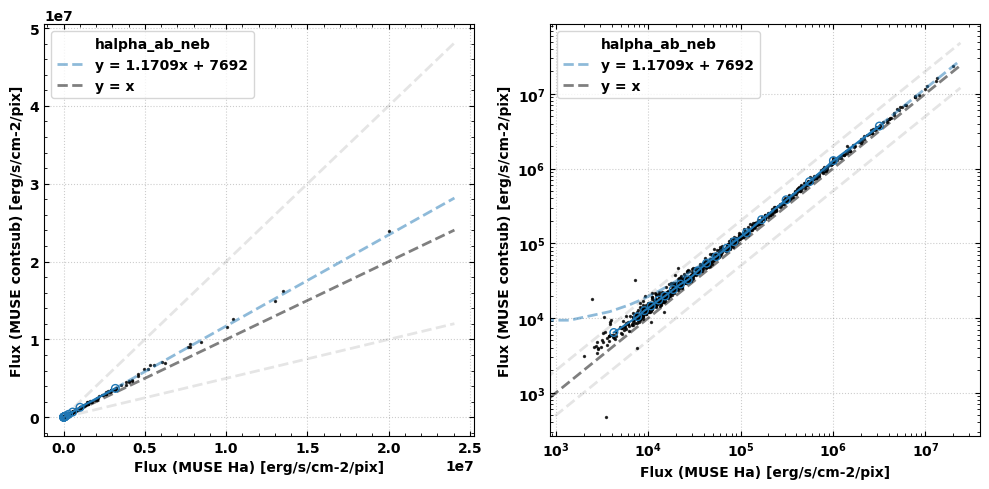

In [8]:
get_anchoring_plotonly(hdu_muse['HA6562_FLUX'], hdu_muse_halpha, hdu_hst_an_halpha, hdu_muse_neb, 'halpha_ab_neb', rootdir)

0.47229665171683727
0.7918947576182459
0.4470822837469
1.0486564164553243


()

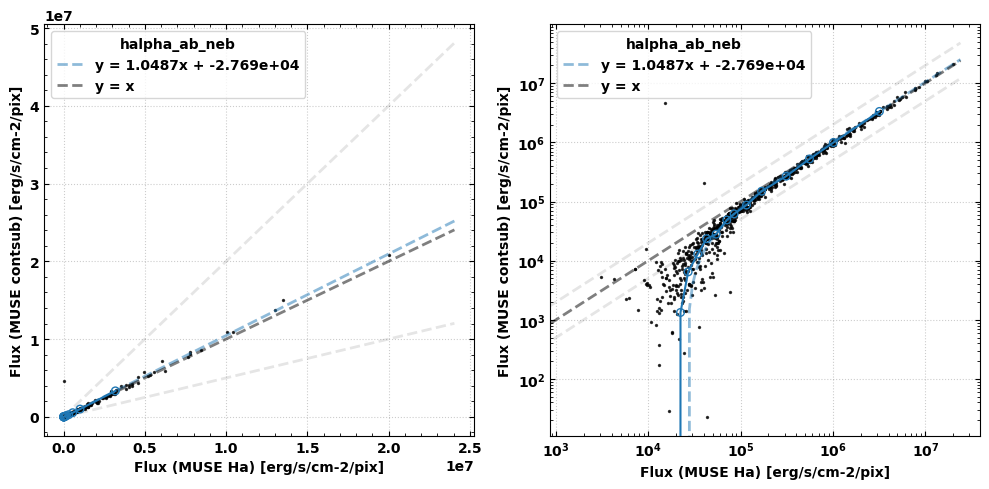

In [9]:
get_anchoring_plotonly(hdu_muse['HA6562_FLUX'], hdu_hst_an_halpha_smre, hdu_hst_an_halpha, hdu_muse_neb, 'halpha_ab_neb', rootdir)

0.9116813914464891
0.8997039593512741
0.9155669868914823
0.9182023415473206


()

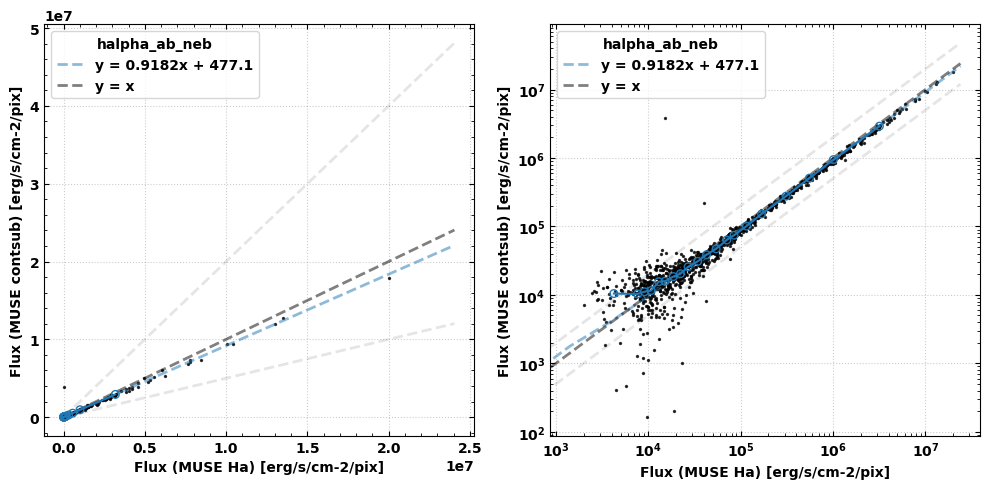

In [10]:
get_anchoring_plotonly(hdu_muse['HA6562_FLUX'], hdu_hst_an_halpha_scaled1_smre, hdu_hst_an_halpha, hdu_muse_neb, 'halpha_ab_neb', rootdir)

2.1090173386260744
1.3619328436912186
2.045208762005272
1.0650660084276642


()

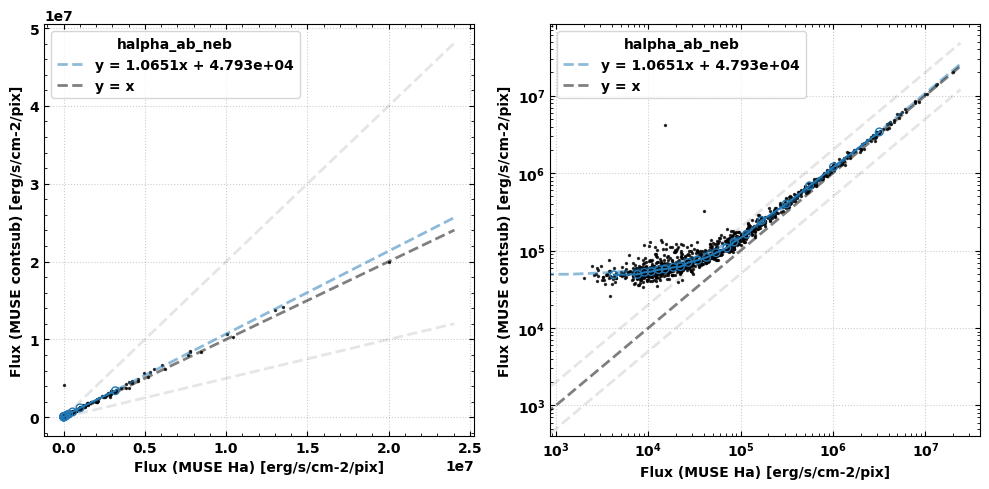

In [11]:
get_anchoring_plotonly(hdu_muse['HA6562_FLUX'], hdu_hst_an_halpha_scaled2_smre, hdu_hst_an_halpha, hdu_muse_neb, 'halpha_ab_neb', rootdir)

In [12]:
hdu_hst_an_halpha_scaled2, hdu_muse_an_halpha_scaled2, _ = get_anchoring_slope(hdu_muse['HA6562_FLUX'], hdu_hst_an_halpha_smre, hdu_hst_an_halpha, hdu_muse_neb, 'halpha_ab_neb', rootdir)

In [ ]:
# Make check plots
hdu_hst_an_halpha_scaled2_sm = get_smooth(hdu_hst_an_halpha_scaled2, hst_res, muse_res)
hdu_hst_an_halpha_scaled2_smre = get_regrid(hdu_hst_an_halpha_scaled2_sm, hdu_muse_f555w)

In [ ]:
def make_plots_fluxsubmasks(hdu1, hdu2, hdu_neb, filter='', rootdir='./', appdir='hst_contsub/'):

    data_neb = hdu_neb.data.copy()
    mids = list(np.unique(data_neb))
    mids.remove(-1)

    flux_1 = np.ones(len(mids))
    flux_2 = np.ones(len(mids))

    for i, mid in enumerate(mids):
        mask = data_neb == mid
        flux_1[i] = np.nansum(hdu1.data[mask])
        flux_2[i] = np.nansum(hdu2.data[mask])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(flux_2[flux_2!=0], flux_2[flux_2!=0]/flux_1[flux_2!=0], fc='none', ec='C0')

    ax.grid(True, ls=':', color='k', alpha=0.2)
    ax.set_ylim(0, 2)
    ax.set_xscale('log')

    plt.tight_layout()
    fig.savefig(rootdir+appdir+'/figs/flux_nebmasks_%s.png' %filter, bbox_inches='tight', dpi=300)
    plt.close('all')

    median = np.nanmedian(flux_2[flux_2!=0]/flux_1[flux_2!=0])
    print('[INFO] Median flux ratio: %0.3f' %(median))

# make_plots_fluxsubmasks(hdu_muse['HA6562_FLUX'], hdu_hst_an_halpha_smre, hdu_muse_neb, 'halpha_neb', rootdir)
# make_plots_fluxsubmasks(hdu_muse['HA6562_FLUX'], hdu_hst_an_halpha_scaled_smre, hdu_muse_neb, 'halpha_ab_neb', rootdir)
make_plots_fluxsubmasks(hdu_muse['HA6562_FLUX'], hdu_hst_an_halpha_scaled2_smre, hdu_muse_neb, 'halpha_ab_neb', rootdir)
# make_plots_fluxsubmasks(hdu_muse['HA6562_FLUX'], hdu_muse_halpha, hdu_muse_neb, 'halpha_muse_neb', rootdir)

In [ ]:
# Anchor Ha flux to MUSE
hdu_hst_halpha_scaled, hdu_muse_halpha_scaled, fit_halpha = get_anchoring_slope(hdu_muse['HA6562_FLUX'], hdu_muse_halpha, hdu_hst_halpha, hdu_muse_neb, 'halpha_neb', rootdir)
hdu_hst_an_halpha_scaled, hdu_muse_an_halpha_scaled, fit_an_halpha = get_anchoring_slope(hdu_muse['HA6562_FLUX'], hdu_muse_halpha, hdu_hst_an_halpha, hdu_muse_neb, 'halpha_ab_neb', rootdir)

# Save fits to table 
save_fittables_offsets(fit_f555w, fit_f65Xn, fit_f814w, rootdir)
save_fittables_slope(fit_halpha, fit_an_halpha, rootdir)

# Make check plots
hdu_hst_an_halpha_scaled_sm = get_smooth(hdu_hst_an_halpha_scaled, hst_res, muse_res)
hdu_hst_an_halpha_scaled_smre = get_regrid(hdu_hst_an_halpha_scaled_sm, hdu_muse_f555w)
make_plots_fluxsubmasks(hdu_muse['HA6562_FLUX'], hdu_hst_an_halpha_scaled_smre, hdu_muse_neb, 'halpha_ab_neb', rootdir)

# Make maps plots
make_plots_map(hdu_hst_an_halpha_scaled, galaxy, 'hst_ha', rootdir)

# Save files
write_hdu(hdu_hst_f555w_smre, rootdir, 'hdu_hst_f555w_smre.fits')
write_hdu(hdu_hst_f65Xn_smre, rootdir, 'hdu_hst_%s_smre.fits' %narrowband_filter)
write_hdu(hdu_hst_f814w_smre, rootdir, 'hdu_hst_f814w_smre.fits')

write_hdu(hdu_hst_f555w, rootdir, 'hdu_hst_f555w.fits')
write_hdu(hdu_hst_f65Xn, rootdir, 'hdu_hst_%s.fits' %narrowband_filter)
write_hdu(hdu_hst_f814w, rootdir, 'hdu_hst_f814w.fits')

write_hdu(hdu_muse_f555w, rootdir, 'hdu_muse_f555w.fits')
write_hdu(hdu_muse_f65Xn, rootdir, 'hdu_muse_%s.fits' %narrowband_filter)
write_hdu(hdu_muse_f814w, rootdir, 'hdu_muse_f814w.fits')

write_hdu(hdu_hst_f555w_an, rootdir, 'hdu_hst_f555w_an.fits')
write_hdu(hdu_hst_f65Xn_an, rootdir, 'hdu_hst_%s_an.fits' %narrowband_filter)
write_hdu(hdu_hst_f814w_an, rootdir, 'hdu_hst_f814w_an.fits')

# write_hdu(hdu_hst_f65Xn_anf, rootdir, 'hdu_hst_%s_anf.fits' %narrowband_filter)

write_hdu(hdu_muse_halpha, rootdir, 'hdu_muse_%s_contsub.fits' %narrowband_filter)
write_hdu(hdu_hst_an_halpha, rootdir, 'hdu_hst_%s_an_contsub.fits' %narrowband_filter)
write_hdu(hdu_hst_halpha, rootdir, 'hdu_hst_%s_contsub.fits' %narrowband_filter)

write_hdu(hdu_muse_cont, rootdir, 'hdu_muse_%s_cont.fits' %narrowband_filter)
write_hdu(hdu_hst_an_cont, rootdir, 'hdu_hst_%s_an_cont.fits' %narrowband_filter)
write_hdu(hdu_hst_cont, rootdir, 'hdu_hst_%s_cont.fits' %narrowband_filter)

write_hdu(hdu_muse['HA6562_FLUX'], rootdir, 'hdu_muse_ha.fits')
write_hdu(hdu_hst_halpha_scaled, rootdir, 'hdu_hst_ha.fits')
write_hdu(hdu_hst_an_halpha_scaled, rootdir, 'hdu_hst_an_ha.fits')